# Twitter Data Visualisation

In today’s connected world it is relatively easy to share individual thoughts and moments with the people. The evolution of social media is only making it easier. I was always intrigued by the questions that how the thought leaders in different domains are influencing people through social media and is there any common characteristics that can be found in their shared content. When initially the influencers put more domain or competency focused contents in professional networks like LinkedIn, but in last few years they are equally giving importance to other social medias like Twitter, Facebook etc. In that context, I considered a list of all influencers in Data Science domain, published by Onalytica. In this report, I will try to provide my findings on those two questions mentioned.

### importing the necessary python libraries

In [1]:
import os
import re
import sys
import csv
import glob
import json
import time
import nltk
import folium
import gensim
import string
import tweepy
import pickle
import logging
import twitter
import warnings
import pyLDAvis
import numpy as np
import urllib.parse
import pandas as pd
import networkx as nx
import pyLDAvis.gensim
from tweepy import Stream
from gensim import corpora
from tweepy import OAuthHandler
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tweepy.streaming import StreamListener
from nltk.stem.wordnet import WordNetLemmatizer
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UserWarning, module='re')
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

Onalytica published a list of 100 most influential people in social media, who are considered thought leaders in Data Science domain. I used the list of their twitter handles to extract all tweets within a maximum allowable limit (~3200 tweets per twitter handle).

In [ ]:
# variables that contains the user credentials to access Twitter API 
access_token = "XXXXXXXXXXXXXXXXX"
access_token_secret = "XXXXXXXXXXXXXXX"
consumer_key = "XXXXXXXXXXXXXXXXX"
consumer_secret = "XXXXXXXXXXXXXXXXXXX"


### For the first time ran this script to get all tweets data. No need to run again.

In [ ]:
def GetUserTweets(screen_name):
    # twitter authorization
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth)
    
    # initialize a list to hold all the Tweets from one twitter handle
    usertweets = []    
    
    # initial api call to get current tweets from user timeline (maximum count 200)
    current_tweets = api.user_timeline(screen_name = screen_name,count=200)
    
    # save the recent tweets and id of last available tweet
    usertweets.extend(current_tweets)
    last_tweet_id = usertweets[-1].id - 1
    
    # get the tweets until maximum limit reached
    while len(current_tweets) > 0:
        # all subsiquent requests use the max_id param to prevent duplicates
        current_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=last_tweet_id)
        
        #save most recent tweets
        usertweets.extend(current_tweets)
        
        #update the id of the last_tweet_id tweet less one
        last_tweet_id = usertweets[-1].id - 1
        
        #print(len(usertweets)," tweets downloaded so far")
    
    #transform the tweepy tweets into a 2D array that will populate the csv    
    outtweets = [[tweet.user.screen_name,tweet.id, tweet.created_at, tweet.text.encode("utf-8"),tweet.retweet_count,tweet.favorite_count] for tweet in alltweets]
    
    #write the csv    
    with open('%s_tweets.csv'%screen_name, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["screen_name","id","created_at","text","retweet_count","favorite_count"])
        writer.writerows(outtweets)
    pass


if __name__ == '__main__':
    # passing the twitter handle names in a list
    screen_names = ['Werner', 'Fisher85M', 'KirkDBorne', 'schmarzo', 'gp_pulipaka','robdthomas','Ronald_vanLoon','JacBurns_Comext','drob','alevergara78','dpatil','hadleywickham','MikeQuindazzi','revodavid','merv','hmason','josephsirosh','TonyBaer','rwang0','jakevdp','PyImageSearch','evankirstel','dhinchcliffe','JimMarous','DeepLearn007','insideBigData','fchollet','andi_staub','jeffbarr','bigdata','BernardMarr','antgrasso','jblefevre60','Doug_Laney','andrewbrust','marcusborba','PetiotEric','randal_olson','timoreilly','YvesMulkers','dez_blanchfield','cloudpreacher','SpirosMargaris','bobehayes','juliasilge','maryjofoley','tamaradull','BigDataGal','chboursin','TamaraMcCleary','opencpu','sckottie','ThorOlavsrud','LouisColumbus','dataandme','idigdata','timoelliott','jameskobielus','JennyBryan','BobViolino','tanyacash21','ahier','DiegoKuonen','JimHarris','acoliver','mattmayo13','GilPress','IIoT_World','TopCyberNews','MHiesboeck','thomasp85','data_nerd','BourseetTrading','reach2ratan','debashis_dutta','AmeliaMN','ValaAfshar','pierrepinna','GlenGilmore','LouisSerge','hugobowne','jimhester_','ammr','sharon000','gcosma1','DynamicWebPaige','CMastication','_ColinFay','LucyStats','2morrowknight','kierisi','nj_tierney','jscarto','ClausWilke','beeonaposy','kearneymw','mjcavaretta','geoff_deweaver']
    for screen_name in screen_names:
        GetUserTweets(screen_name)
    

### Reading all files containing tweets

In [3]:
# defining single dataframe for all tweets data from all twitter handles
os.chdir('/Users/santanubhattacharjee/Data/alltwitts/')
df = pd.concat([pd.read_csv(f) for f in glob.glob('*.csv')], ignore_index = True)

# saving last one year tweets and retweets count to csv
#(df.groupby(['screen_name']).agg(['count'])).to_csv('tweet_count.csv')
#df.groupby(['screen_name']).agg({'retweet_count': 'sum', 'favorite_count': 'sum'}).to_csv('retweet_fav.csv')

# converting date from string to date-time
df['date'] = pd.to_datetime(df['created_at'])

# considering last one year data for this analysis (1-Dec-2017 till 1-Dec-2018)
df_last_1yr = df[(df['date'] > '2017-12-01')]

### Reading map data

In [4]:
map_df = pd.read_csv('/Users/santanubhattacharjee/Data/alltwitts/OtherData/names.csv', encoding = "ISO-8859-1")
map_df.head()

,screen_name,full_name,city,followers_count,tweets_count,retweets_count,favourites_count,latitude,longitude,image_link
0,_ColinFay,Colin Fay,RennesFrance,5.8K,3220,609690,21347,48.111980,-1.674290,https://pbs.twimg.com/profile_images/105429778...
1,2morrowknight,Sean Gardner,Zagreb,879K,3221,1413918,34298,45.815399,15.966568,https://pbs.twimg.com/profile_images/103242687...
2,acoliver,Andrew C. Oliver,Durham NC,1.8K,3222,7163024,1869,35.994034,-78.898621,https://pbs.twimg.com/profile_images/462807799...
3,ahier,Brian Ahier,Washington D.C. Metro Area,54.3K,3226,497530,12793,38.800497,-77.407507,https://pbs.twimg.com/profile_images/807711178...
4,alevergara78,Alejandro Vergara,Santiago Chile,15.2K,3098,153387,0,-33.459229,-70.645348,https://pbs.twimg.com/profile_images/477167045...


In [5]:
# map initialization
folium_map = folium.Map(location=[30.4202, -9.5982], zoom_start=2, tiles="cartodbpositron")

# iterate over map dataframe to draw the circles on map; circles are indicating all listed thought leaders current location
for index, row in map_df.iterrows():
    popup_text = """
                <img src={} style="width:50px;height:50px;"><br>
                <b>{}</b><br>
                Twitter Handle: {}<br> 
                Followers: {}<br>
                Tweets(last 1 yr): {}<br>
                Retweets(last 1 yr): {}<br>
                Likes(last 1 yr): {}"""
    
    popup_text = popup_text.format(row["image_link"],
                               row["full_name"],
                               row["screen_name"],
                               row["followers_count"],
                               row["tweets_count"],
                               row["retweets_count"],
                               row["favourites_count"])
    
    tooltip = row["full_name"]
    
    folium.Marker(location=(float(row["latitude"]),float(row["longitude"])),
                  icon=folium.Icon(icon='twitter',prefix='fa', color='blue'),
                  popup=popup_text,
                  tooltip=tooltip).add_to(folium_map)


### Visualise Map

In [16]:
folium_map

Data Analysis:

• At first view, I can see that top influencers are concentrated mostly in two continents: North America and Europe. Top two cities where they are mostly based on are Seattle and New York City.

• The influence level can be easily understood from few basic metrics as collected or aggregated. They have together 9.4 million followers on Twitter.

• In last one year, they have tweeted more than 2,34,000 times on their twitter handle. Their messages got retweeted more than 102 million times.

• All those tweets got 3.9 million likes in total.


### Creating nodes and links for showing inter-relationship between twitter handles

In [8]:
# dataframe containing all tweets along with all mentions within tweets
df_last_1yr['mentions'] = df_last_1yr['text'].str.extract('RT @([a-zA-Z0-9]\w{0,})')
filtered_df = df_last_1yr[df_last_1yr['mentions'].notnull()]

'''
Finding mention graph edges between tweeter handles
Source: thought leaders' twitter handles
target: all mentions by thought leaders in their tweets
value: total number of mentions
'''
edges = pd.DataFrame(columns = ('source','target','value'))
edges['source'] = filtered_df['screen_name']
edges['target'] = filtered_df['mentions']
edges['value'] = filtered_df['created_at']
edges_1 = edges.groupby(['source','target'])['value'].count().astype(int)
edges_1 = edges_1.reset_index()
edges_1 = edges_1[edges_1['value'] > 5]

'''
Finding mention graph nodes representing tweeter handles
index: index of record
group: grouping of these tweeter handles
name: twitter handles of thought leaders'

Group 1: personal tweeter handles
Group 2: crypto currency, bit coin, block chain
Group 3: Statistics, machine learning, AI, data science
Group 4: IOT
Group 5: Cyber Security
Group 6: Business Summit, Conference
Group 7: Start-ups, Entrepreneurs
Group 8: Business, Innovation, Digital Transformation
Group 9: students, programming
Group 10: Promoting gender diversity in R Stat Community
Group 11: others
'''
nodes = pd.DataFrame(columns = ('index','group','name'))
arr = pd.unique(edges_1[['source', 'target']].values.ravel('K'))
nodes['name'] = arr

# all screen names
screen_names = ['Werner', 'Fisher85M', 'KirkDBorne', 'schmarzo', 'gp_pulipaka','robdthomas','Ronald_vanLoon','JacBurns_Comext','drob','alevergara78','dpatil','hadleywickham','MikeQuindazzi','revodavid','merv','hmason','josephsirosh','TonyBaer','rwang0','jakevdp','PyImageSearch','evankirstel','dhinchcliffe','JimMarous','DeepLearn007','insideBigData','fchollet','andi_staub','jeffbarr','bigdata','BernardMarr','antgrasso','jblefevre60','Doug_Laney','andrewbrust','marcusborba','PetiotEric','randal_olson','timoreilly','YvesMulkers','dez_blanchfield','cloudpreacher','SpirosMargaris','bobehayes','juliasilge','maryjofoley','tamaradull','BigDataGal','chboursin','TamaraMcCleary','opencpu','sckottie','ThorOlavsrud','LouisColumbus','dataandme','idigdata','timoelliott','jameskobielus','JennyBryan','BobViolino','tanyacash21','ahier','DiegoKuonen','JimHarris','acoliver','mattmayo13','GilPress','IIoT_World','TopCyberNews','MHiesboeck','thomasp85','data_nerd','BourseetTrading','reach2ratan','debashis_dutta','AmeliaMN','ValaAfshar','pierrepinna','GlenGilmore','LouisSerge','hugobowne','jimhester_','ammr','sharon000','gcosma1','DynamicWebPaige','CMastication','_ColinFay','LucyStats','2morrowknight','kierisi','nj_tierney','jscarto','ClausWilke','beeonaposy','kearneymw','mjcavaretta','geoff_deweaver']

# grouping of all thought leaders
for idx,row in nodes.iterrows():
    if row['name'] in screen_names:
        row['group'] = '1'


/Users/santanubhattacharjee/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  
/Users/santanubhattacharjee/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Filter all links with threshold value

In [9]:
os.chdir('/Users/santanubhattacharjee/Data/alltwitts/Otherdata/')
nodes = pd.read_csv('nodes.csv')
#edges_1 = pd.read_csv('edges_1.csv')
edges_2 = edges_1[edges_1['source'] != edges_1['target']]

value_threshold = 200
nodes_1 = nodes[((nodes['group'] == 1) | (nodes['group'] == 2)) & (~nodes['name'].isin(screen_names))]
nodes_list = list(nodes_1['name'])
edges_3 = pd.DataFrame(columns=('source','target','value'))
for idx,row in edges_2.iterrows():
    if (row['value'] > value_threshold) or (row['target'] not in nodes_list):
        edges_3 = edges_3.append(row)
    
arr_1 = pd.unique(edges_3[['source', 'target']].values.ravel('K'))
names_list = list(arr_1)
nodes_2 = nodes[nodes['name'].isin(names_list)]

### Importing few additional libraries to view  chord chart

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
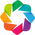

In [13]:
import holoviews as hv
from bokeh.sampledata.les_mis import data
from bokeh.plotting import figure, output_file, save

hv.extension('bokeh')
%output size=200

### Prepare the nodes and links

In [ ]:
links_list = []
nodes_2 = nodes_2.sort_values('group')
nodes = hv.Dataset(nodes_2[['group','name']], 'index')
nodes_dict = pd.Series(nodes.data.index.values,index=nodes.data.name).to_dict()

for idx,row in edges_3.iterrows():
    links_list.append({"source": nodes_dict[row['source']], "target": nodes_dict[row['target']], "value": row['value']})

links1 = pd.DataFrame(links_list)
links = links1.sort_values('source')
links = links.reset_index(drop=True)
hv.Chord(links)

### Visualize chord chart

In [15]:
%%opts Chord [color_index='group' edge_color_index='source'] 
%%opts Chord (cmap='Category20' edge_cmap='Category20')
hv.Chord((links, nodes)).select(value=(5, None))

:Chord   [source,target]   (value)

Data Analysis:

• The edge color index is based on source of the tweets. It can be inferred that, the thought leaders used to mention other leaders very frequently in their tweets. They could have done that by either mentioning others’ work published in different media or by re-sharing their contents from timeline.

• They also mention about other relevant community twitter handles across domains. In this way they are actually sharing more valuable contents over social media. AI, Blockchain, IOT, Cyber Security are on the top mentions’ category in their tweets.

• Few Red lines at bottom are showing their mentions on Business Summit and Conferences in Data Science, Blockchain etc. In this way their followers would be more informed about upcoming conferences and meet-ups.

### Preprocess text data and save dictionary, corpus and lda model as pickle file on local system. No need to run if these files are already available

In [ ]:
Strings_List = [s for s in df_last_1yr['text']]
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
restricted_words = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','xe','xf','xd','xef','xa','xb','xba','xaa','xc','de','le','co','rt','gt','http','nan','inf','nhttps']

def preprocess(elem):
    bracket_free = re.sub('[\(\[].*?[\)\]]', '', elem)
    special_char_free = re.sub('[^A-Za-z]+', ' ', bracket_free)
    stop_free = " ".join([j for j in special_char_free.lower().split() if j not in stop])
    punc_free = ''.join(k for k in stop_free if k not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    rest_free_words = ' '.join(i for i in normalized.split() if i not in restricted_words)
    return rest_free_words

Strings_List_clean_1 = [preprocess(elem).split() for elem in Strings_List]

Strings_List_clean = []
for item in Strings_List_clean_1:
    if len(item) > 6:
        Strings_List_clean.append(item)

# Making the term dictionary
dictionary = corpora.Dictionary(Strings_List_clean)

# Making the corpus
corpus = [dictionary.doc2bow(text) for text in Strings_List_clean]

# Making the object for LDA model
Lda = gensim.models.ldamodel.LdaModel

ldamodel = Lda(corpus, num_topics=10, id2word = dictionary, passes=4)

''''
with open("dictionary.pkl", "wb") as fp1:
    pickle.dump(dictionary, fp1)
with open("corpus.pkl", "wb") as fp2:
    pickle.dump(corpus, fp2)
with open("ldamodel.pkl", "wb") as fp3:
    pickle.dump(ldamodel, fp3)
'''

pyLDAvis.display(pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary))

Data Analysis:

• The very first topic is all about different technologies like AI, IOT, Data Science, Bigdata etc. The fifth topic is quite intersected with topic 1 and it mainly focus on machine learning, deep learning, nlp, programming.

• Topic three is mostly discussed on statistics, R, R Studio, ggplot etc.

• Topic four is defined by shared content on blog post and other writings shared by these influencers.

• Topic seven is about banking and financial content. Top pics are ‘fintech’, ‘banking’, ‘insurtech’, ‘finserv’ (with lambda 0.33 on top sliding contron)

• Apart from that they also talk about other different relevant topics like smart city, cyber security, digital transformations etc. 

### Visualize top ten topics of discussion

In [12]:
pyLDAvis.display(pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary))

### Save the visualization on local drive

In [ ]:
p = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.save_html(p, 'lda.html')